In [1]:
import sys
sys.path.append("/home/yike/phd/dengue/dengue_children/pilots/zhiyuan") #enter the lib.util file directory
import util
from util import *

In [2]:
%config Completer.use_jedi = False
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *

print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
print('normalize data to CPM (counts per million)')
sc.pp.normalize_total(adata, target_sum=1e6)
        
print('Restrict to interaction genes')
genes = np.unique(interactions)
genes = [i for i in genes if i in adata.var_names] # genes = genes - ['CCL3L3', 'CCL4L1', 'CCN6', 'KIR3DS1', 'YARS1']
adatag = adata[:, genes]

Load interaction
Load high-quality cells only
normalize data to CPM (counts per million)
Restrict to interaction genes


In [3]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']

In [4]:
pair = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_cells/pair.tsv', sep='\t', index_col=['cell_type', 'gene'])

In [5]:
ex_genes = []
for gene in ['IGKV', 'IGHV', 'IGLV', 'IGLC', 'IGKC', 'IGHC', 'TRAV', 'TRBV']:
    ex_genes = ex_genes + adata_children.var_names[adata_children.var_names.str.startswith(gene)].tolist()
    
pair.reset_index(inplace=True)
pair = pair[~pair['gene'].isin(ex_genes)]
pair.set_index(['cell_type', 'gene'], inplace=True)

In [6]:
def merge(df_kid, df_adult):
    intersect = [x for x in df_kid.index if x in df_adult.index]
    df_adult.columns = ['med_pair_a', 'fra_pair_a']
    df = pd.concat([df_kid.loc[intersect, :], df_adult.loc[intersect, :]], axis=1)
    return(df)

def df_merge_processing(df_merge):
    ind_CD4 = df_merge.loc[(df_merge['fra_pair'] >= 0.7) | (df_merge['fra_pair'] <= 0.3),:].index
    ind_CD8 = df_merge.loc[(df_merge['fra_pair_a'] >= 0.7) | (df_merge['fra_pair_a'] <= 0.3),:].index
    ind_merge = [x for x in ind_CD4 if x in ind_CD8]
    df_merge['outlier'] = 'no'
    df_merge.loc[ind_CD4, 'outlier'] = 'CD4_only'
    df_merge.loc[ind_CD8, 'outlier'] = 'CD8_only'
    df_merge.loc[ind_merge, 'outlier'] = 'both'
    
    x_mean = df_merge['med_pair'].mean()
    y_mean = df_merge['med_pair_a'].mean()
    df_merge['distance'] = np.sqrt((df_merge['med_pair'] - x_mean)**2 + (df_merge['med_pair_a'] - y_mean)**2)
    df_merge['distance_x'] = df_merge['med_pair'] - x_mean
    df_merge['distance_y'] = df_merge['med_pair_a'] - y_mean
    
    df_merge_2 = df_merge[df_merge.distance >= df_merge.distance.quantile(q = 0.95)]
    radius = df_merge_2.sort_values(by = 'distance').iloc[0, 5]
    
    markers_1 = df_merge_2.loc[(df_merge_2['distance_x'] > radius/np.sqrt(2)) & (df_merge_2['distance_y'] > radius/np.sqrt(2))].index
    markers_2 = df_merge_2.loc[(df_merge_2['distance_x'] < -radius/np.sqrt(2)) & (df_merge_2['distance_y'] > radius/np.sqrt(2))].index
    markers_3 = df_merge_2.loc[(df_merge_2['distance_x'] < -radius/np.sqrt(2)) & (df_merge_2['distance_y'] < -radius/np.sqrt(2))].index
    markers_4 = df_merge_2.loc[(df_merge_2['distance_x'] > radius/np.sqrt(2)) & (df_merge_2['distance_y'] < -radius/np.sqrt(2))].index
    
    df_merge['markers'] = 'no'
    df_merge.loc[markers_1, 'markers'] = '1'
    df_merge.loc[markers_2, 'markers'] = '2'
    df_merge.loc[markers_3, 'markers'] = '3'
    df_merge.loc[markers_4, 'markers'] = '4'
    
    return(df_merge, radius)

In [63]:
def scatter_pairwise_2(df_merge, radius, marklist, path, name, filetype):
    fig, ax = plt.subplots()
    rcParams['figure.figsize']=(5, 5)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    
    sb.scatterplot(x = 'med_pair', y = 'med_pair_a', data = df_merge, ax = ax, hue = 'markers', 
                   palette = ['grey', 'red', 'purple', 'orange',], edgecolor=None, s=10)
    
    
    sb.kdeplot(x = 'med_pair', y = 'med_pair_a', data = df_merge.loc[:,['med_pair', 'med_pair_a']], ax = ax)
    
    x_mean = df_merge['med_pair'].mean()
    y_mean = df_merge['med_pair_a'].mean()
    ax.axvline(x=x_mean, ls = '--', c = 'black', lw = 2)
    ax.axhline(y=y_mean, ls = '--', c = 'black', lw = 2)
    
#     df_temp = df_merge[df_merge.markers != 'no']
    mark_list = marklist
    for gene in mark_list:
        ax.text(df_merge.loc[gene, 'med_pair']-0.6, 
        df_merge.loc[gene, 'med_pair_a'] + 0.005,
        gene, color = 'black',
        fontsize = 10)
        
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)
# Draw 8 slices using Fabio's function  
    draw_8_slices(ax, (x_mean, y_mean), radius=radius, r_sin=radius/np.sqrt(2))
    ax.set_xlabel('log2 fold change CD4 T cells')
    ax.set_ylabel('log2 fold change CD8 T cells')
    
    ax.set_title('SD vs D')
    ax.get_legend().remove()
    
    filename = name + '.' + filetype
    fig.savefig(os.path.join(path, filename), bbox_inches = 'tight')
    
    
#Fabio's function
def draw_8_slices(ax, center, radius=1.0, r_sin=1.0):
    def cp(amin, amax, center, ndots=100):
            xc, yc = center
            angles = np.linspace(amin, amax, ndots)
            xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
            return [(xi, yi) for xi, yi in zip(xcircs, ycircs)][::-1]

    def draw_wedge(ax, points, color):
            points = np.array(points)
            center = points.mean(axis=0)
            delta = points - center
            points = center + 0.99 * delta

            rgb = list(mpl.colors.to_rgba(color)[:-1])
            rgba_edge = tuple(rgb + [0.6])
            rgba_fill = tuple(rgb + [0.2])
            ax.add_artist(plt.Polygon(
                points, edgecolor=rgba_edge, facecolor=rgba_fill, lw=2,
                clip_on=False,
                ))

    xc, yc = center
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Cross
    ax.axvline(xc, ls='--', color='k')
    ax.axhline(yc, ls='--', color='k')

    # Circle
    rgb = list(mpl.colors.to_rgba('grey'))[:-1]
    circle = plt.Circle(center, radius, facecolor=tuple(rgb + [0.2]), edgecolor='k')
    ax.add_artist(circle)

    # Wedges
    # 1. intersections with circle
#     angles = 2 * np.pi / 8 * (np.arange(8) + 0.5)

    angles = np.array([np.arcsin(r_sin/radius), np.arccos(r_sin/radius), 
                       np.pi-np.arccos(r_sin/radius), np.pi - np.arcsin(r_sin/radius),
                       np.pi+np.arcsin(r_sin/radius), np.pi+np.arccos(r_sin/radius), 
                       2*np.pi-np.arccos(r_sin/radius), 2*np.pi-np.arcsin(r_sin/radius)])
    
#     xcircs = np.array([np.sqrt(radius**2 - r_sin), r_sin, -r_sin, -np.sqrt(radius**2 - r_sin), 
#                        -np.sqrt(radius**2 - r_sin), -r_sin, r_sin, np.sqrt(radius**2 - r_sin)]) - xc
#     ycircs = np.array([r_sin, np.sqrt(radius**2 - r_sin), np.sqrt(radius**2 - r_sin), r_sin, 
#                        -r_sin, -np.sqrt(radius**2 - r_sin), -np.sqrt(radius**2 - r_sin), -r_sin]) - yc
    
    xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
    circs = np.vstack([xcircs, ycircs]).T
    
    # 2. Intersections with axes border
    xbords, ybords = [], []
    # bords[0]
    xbords.append(xmax)
    ybords.append(yc + r_sin)
    # bords[r_sin]
    xbords.append(xc + r_sin)
    ybords.append(ymax)
    # bords[2]
    xbords.append(xc - r_sin)
    ybords.append(ymax)
    # bords[3]
    xbords.append(xmin)
    ybords.append(yc + r_sin)
    # bords[4]
    xbords.append(xmin)
    ybords.append(yc - r_sin)
    # bords[5]
    xbords.append(xc - r_sin)
    ybords.append(ymin)
    # bords[6]
    xbords.append(xc + r_sin)
    ybords.append(ymin)
    # bords[7]
    xbords.append(xmax)
    ybords.append(yc - r_sin)

    bords = np.vstack([xbords, ybords]).T

    # 3. draw wedges
    draw_wedge(ax, [circs[0], bords[0], (xmax, ymax), bords[1], circs[1]] + cp(angles[0], angles[1], center),
               color='purple')
    draw_wedge(ax, [circs[1], bords[1], bords[2], circs[2]] + cp(angles[1], angles[2], center), 
               color='grey')
    draw_wedge(ax, [circs[2], bords[2], (xmin, ymax), bords[3], circs[3]] + cp(angles[2], angles[3], center), 
               color='dodgerblue')
    draw_wedge(ax, [circs[3], bords[3], bords[4], circs[4]] + cp(angles[3], angles[4], center), 
               color='lawngreen')
    draw_wedge(ax, [circs[4], bords[4], (xmin, ymin), bords[5], circs[5]] + cp(angles[4], angles[5], center), 
               color='orange')
    draw_wedge(ax, [circs[5], bords[5], bords[6], circs[6]] + cp(angles[5], angles[6], center), 
               color='grey')
    draw_wedge(ax, [circs[6], bords[6], (xmax, ymin), bords[7], circs[7]] + cp(angles[6], angles[7], center), 
               color='tomato')
    draw_wedge(ax, [circs[7], bords[7], bords[0], circs[0]] + cp(angles[7], 2*np.pi+angles[0], center), 
               color='pink')

In [40]:
df_CD4 = pair.loc['CD4_T_cells'][['med_pair', 'fra_pair']]
df_CD8 = pair.loc['CD8_T_cells'][['med_pair', 'fra_pair']]
df_merge = merge(df_CD4, df_CD8)

#df_merge = df_merge[df_merge['med_pair_a'] != 0]
df, radius = df_merge_processing(df_merge)

In [44]:
df_n = df[df['outlier'] == 'both']

In [53]:
df_n[df_n['markers'] == '1'].sort_values('distance', ascending=False).index

Index(['KIF11', 'SHCBP1', 'TRIOBP', 'MLLT1', 'SCRIB', 'NCF2', 'POLR3B', 'PHC2',
       'GPAT2', 'CDYL2', 'ITGA1', 'WDR47', 'ZNRF1', 'SEMA4A', 'NCAPG',
       'AC091057.6', 'RAI1', 'SEC31B', 'CNNM3', 'TCF3', 'CYB5RL', 'EGR1',
       'CELSR3', 'KLHL15', 'KNL1', 'HIST1H3B', 'MCM10', 'CCNA2', 'OTUD1',
       'MMACHC', 'PRKACA', 'HIST1H1B'],
      dtype='object', name='gene')

In [54]:
df_n[df_n['markers'] == '1'].sort_values('distance_x', ascending=False).index

Index(['ITGA1', 'NCF2', 'AC091057.6', 'KIF11', 'NCAPG', 'SHCBP1', 'GPAT2',
       'CDYL2', 'CCNA2', 'MCM10', 'KLHL15', 'CELSR3', 'KNL1', 'WDR47', 'PHC2',
       'CYB5RL', 'ZNRF1', 'TRIOBP', 'RAI1', 'POLR3B', 'OTUD1', 'MLLT1',
       'HIST1H3B', 'PRKACA', 'CNNM3', 'HIST1H1B', 'EGR1', 'TCF3', 'SEMA4A',
       'MMACHC', 'SEC31B', 'SCRIB'],
      dtype='object', name='gene')

In [55]:
df_n[df_n['markers'] == '1'].sort_values('distance_y', ascending=False).index

Index(['KIF11', 'SCRIB', 'MLLT1', 'TRIOBP', 'POLR3B', 'SHCBP1', 'PHC2',
       'SEMA4A', 'WDR47', 'CDYL2', 'ZNRF1', 'GPAT2', 'NCF2', 'SEC31B', 'RAI1',
       'CNNM3', 'TCF3', 'EGR1', 'CYB5RL', 'CELSR3', 'HIST1H3B', 'KLHL15',
       'NCAPG', 'OTUD1', 'MMACHC', 'ITGA1', 'PRKACA', 'KNL1', 'HIST1H1B',
       'AC091057.6', 'MCM10', 'CCNA2'],
      dtype='object', name='gene')

In [60]:
df_n[df_n['markers'] == '2'].sort_values('distance_x', ascending=False).index

Index(['FANCE', 'CORO1C', 'ORC6', 'XRCC2', 'COG8', 'AC018797.2', 'CBX2',
       'AC133550.2', 'CCDC189', 'LINC02265', 'ZNF653', 'USP49', 'TTK',
       'AC008549.2', 'NCAM1', 'WDR90', 'NOMO1', 'AC004943.2', 'AC055713.1',
       'NRGN', 'SUMO4', 'FANCC', 'ZFHX3'],
      dtype='object', name='gene')

In [65]:
df_n[df_n['markers'] == '3'].sort_values('distance_y', ascending=False)

,med_pair,fra_pair,med_pair_a,fra_pair_a,outlier,distance,distance_x,distance_y,markers
gene,,,,,,,,,
CAV1,-1.475745,0.21875,-1.518873,0.21875,both,2.294827,-1.493963,-1.741926,3
IFIT3,-1.572384,0.25000,-1.549608,0.25000,both,2.381668,-1.590603,-1.772661,3
IFIT1,-1.990013,0.28125,-1.844238,0.25000,both,2.882132,-2.008232,-2.067291,3
YPEL1,-1.724992,0.15625,-1.881163,0.06250,both,2.732491,-1.743211,-2.104216,3
EDDM13,-1.545216,0.25000,-1.921730,0.25000,both,2.654133,-1.563434,-2.144783,3
SLC43A2,-1.695974,0.12500,-1.994574,0.28125,both,2.802914,-1.714193,-2.217627,3
IFIT2,-1.741037,0.25000,-2.071857,0.06250,both,2.891642,-1.759255,-2.294910,3
AC010969.2,-1.841694,0.21875,-2.212187,0.15625,both,3.064256,-1.859913,-2.435240,3
UPK2,-2.432434,0.15625,-2.411521,0.09375,both,3.598149,-2.450652,-2.634574,3


In [52]:
df[df['markers'] == '4'].sort_values('distance', ascending=False)

,med_pair,fra_pair,med_pair_a,fra_pair_a,outlier,distance,distance_x,distance_y,markers
gene,,,,,,,,,


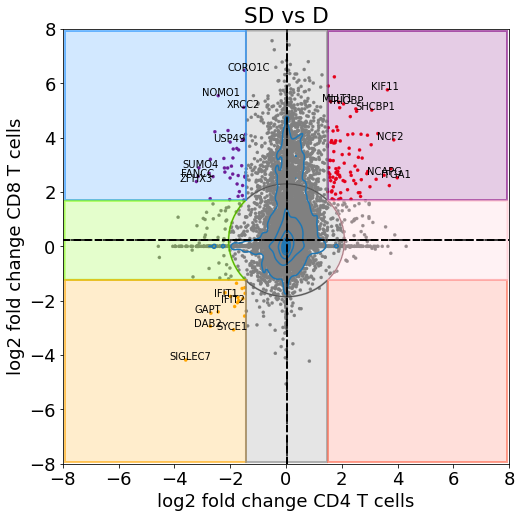

In [67]:
#plotting 2D plot
marklist = ['KIF11', 'SHCBP1', 'TRIOBP', 'MLLT1', 'ITGA1', 'NCF2', 'NCAPG', 
            'CORO1C', 'NOMO1', 'XRCC2', 'USP49', 'SUMO4', 'FANCC', 'ZFHX3',
            'SIGLEC7', 'DAB2', 'GAPT', 'IFIT2', 'IFIT1', 'SYCE1'] 

path = '/home/yike/phd/dengue/figures/paper_figure/figure_V8/T_cells/'
name = 'scatter2'
rcParams['figure.figsize']=(8, 8)
rcParams['savefig.dpi'] = 300
scatter_pairwise_2(df, radius, marklist, path, name, 'png')
# scatter_pairwise_2(df_merge_2, radius, marklist, path, name, 'pdf')

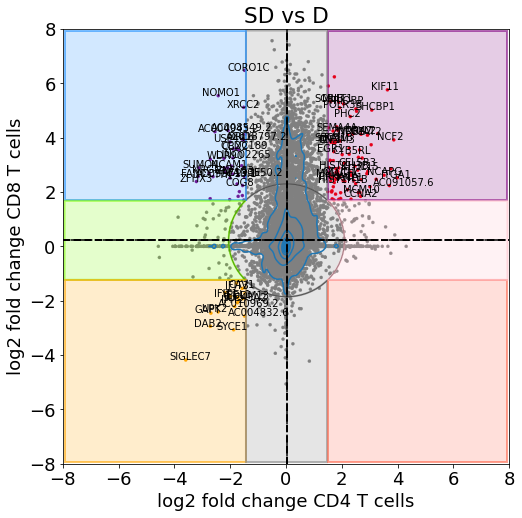

In [73]:
path = '/home/yike/phd/dengue/figures/paper_figure/figure_V8/T_cells/'
name = 'scatter1'
rcParams['figure.figsize']=(8, 8)
rcParams['savefig.dpi'] = 300
marklist = ['ITGA1', 'NCF2', 'AC091057.6', 'KIF11', 'NCAPG', 'SHCBP1', 'GPAT2',
           'CDYL2', 'CCNA2', 'MCM10', 'KLHL15', 'CELSR3', 'KNL1', 'WDR47', 'PHC2',
           'CYB5RL', 'ZNRF1', 'TRIOBP', 'RAI1', 'POLR3B', 'OTUD1', 'MLLT1',
           'HIST1H3B', 'PRKACA', 'CNNM3', 'HIST1H1B', 'EGR1', 'TCF3', 'SEMA4A',
           'MMACHC', 'SEC31B', 'SCRIB', 'CAV1', 'FANCE', 'AC004832.6', 'CORO1C',
           'ORC6', 'XRCC2', 'EDDM13', 'COG8', 'AC018797.2', 'IFIT3', 'SLC43A2',
           'CBX2', 'AC133550.2', 'YPEL1', 'IFIT2', 'CCDC189', 'AC010969.2',
           'SYCE1', 'LINC02265', 'ZNF653', 'IFIT1', 'USP49', 'TTK', 'AC008549.2',
           'NCAM1', 'WDR90', 'NOMO1', 'UPK2', 'AC004943.2', 'AC055713.1', 'GAPT',
           'DAB2', 'NRGN', 'SUMO4', 'FANCC', 'ZFHX3', 'SIGLEC7', ]
scatter_pairwise_2(df, radius, marklist, path, name, 'png')
# scatter_pairwise_2(df_merge_2, radius, marklist, path, name, 'pdf')

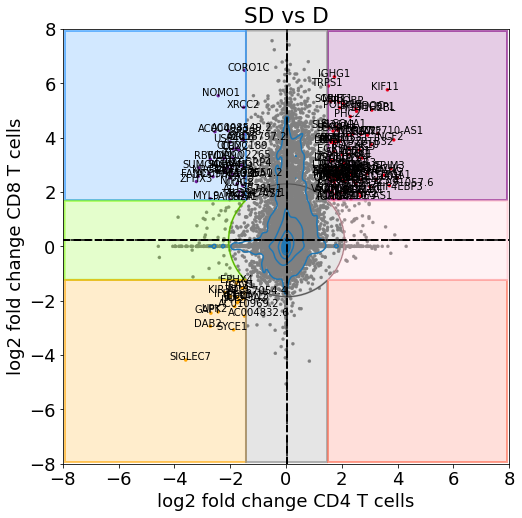

In [77]:
path = '/home/yike/phd/dengue/figures/paper_figure/figure_V8/T_cells/'
name = 'scatter3'
rcParams['figure.figsize']=(8, 8)
rcParams['savefig.dpi'] = 300
scatter_3_list = df[df['markers'] != 'no'].index.tolist()
scatter_pairwise_2(df, radius, scatter_3_list, path, name, 'png')
# scatter_pairwise_2(df_merge_2, radius, marklist, path, name, 'pdf')

In [106]:
df[(df['distance_x'] > 0.5) & (df['distance_y'] > 0.5)].sort_values('distance', ascending=False).head(200).index.tolist()

['ALYREF',
 'KIF11',
 'RAVER1',
 'IGHG1',
 'TCAF2',
 'ZNF318',
 'ABCC1',
 'SREBF1',
 'TRPS1',
 'ZNF333',
 'AMFR',
 'POLR3G',
 'SHCBP1',
 'HIST1H2AI',
 'AGFG2',
 'AIFM2',
 'SPINDOC',
 'CSNK1E',
 'TRIOBP',
 'MLLT1',
 'HIST1H2BL',
 'SCRIB',
 'NCF2',
 'DHTKD1',
 'HIST1H2AJ',
 'POLR3B',
 'SLC27A4',
 'CAD',
 'KCNN4',
 'ZNF710-AS1',
 'ACSL6',
 'PHC2',
 'TRIM65',
 'PLS3',
 'FOXJ2',
 'FAM189B',
 'ZNF598',
 'HIST1H2AB',
 'ZBED4',
 'PKD1',
 'RNF157',
 'ERCC6L',
 'LSM14B',
 'ASRGL1',
 'GPAT2',
 'C3orf62',
 'MCM9',
 'COLGALT1',
 'PCNX2',
 'F5',
 'IBA57',
 'CDYL2',
 'EID2',
 'TMEM91',
 'ZBTB32',
 'DNAJC27',
 'ZBTB37',
 'BICD1',
 'NFE2L3',
 'USP12',
 'C3orf58',
 'DUSP7',
 'ITGA1',
 'WDR47',
 'TRIM3',
 'IL10',
 'MROH1',
 'SLCO4A1',
 'AL031777.3',
 'NPIPA1',
 'PNPLA6',
 'TAF4B',
 'ZNRF1',
 'MARK4',
 'FKRP',
 'N4BP2',
 'TFRC',
 'SLC36A1',
 'AP003392.4',
 'TLE1',
 'RREB1',
 'OTUD3',
 'PLTP',
 'MAN2A2',
 'TMTC3',
 'SEMA4A',
 'SWT1',
 'FAM19A2',
 'CDKL3',
 'CFAP54',
 'TMEM67',
 'SMN1',
 'BMP2K',
 'MAP3K20'

In [105]:
df[(df['distance_x'] < -0.5) & (df['distance_y'] > 0.5)].sort_values('distance', ascending=False).head(200).index.tolist()

['HIST1H2AL',
 'CORO1C',
 'NOMO1',
 'DDX19B',
 'ROPN1L',
 'ABCA2',
 'WHRN',
 'GCAT',
 'XRCC2',
 'PACSIN1',
 'CLCN7',
 'CLN6',
 'COPRS',
 'HIST1H3C',
 'TIGD2',
 'SFXN5',
 'GCNT2',
 'AC004943.2',
 'AC093249.6',
 'LINC00891',
 'AP004609.3',
 'DVL3',
 'AGAP6',
 'AC008549.2',
 'FUT7',
 'FAM229B',
 'FLVCR1-DT',
 'CPLANE2',
 'KCNK6',
 'KMT5C',
 'NSMCE2',
 'MTHFD1L',
 'SPATA24',
 'GPR68',
 'USP49',
 'SPA17',
 'SUMO4',
 'AL731569.1',
 'RBFOX1',
 'AC018797.2',
 'CBY1',
 'CENPBD1',
 'ORC6',
 'N6AMT1',
 'LINC00926',
 'FKBP1C',
 'FANCC',
 'ZFHX3',
 'DPY19L1',
 'ATXN7',
 'CLU',
 'AC108488.1',
 'NFKBIE',
 'ARSD',
 'CCDC189',
 'ZNF829',
 'WDR90',
 'CBX2',
 'C17orf67',
 'ANKS6',
 'MBOAT2',
 'NRGN',
 'AC006329.1',
 'CARD17',
 'KLHL26',
 'ZGRF1',
 'LINC02265',
 'CCDC102A',
 'GPR55',
 'AC055713.1',
 'SOWAHD',
 'LINC01146',
 'MIR4422HG',
 'NCAM1',
 'TSEN2',
 'GRK3',
 'GLB1L',
 'MYB',
 'NREP',
 'KHDC4',
 'ABCG2',
 'CBX8',
 'SCOC-AS1',
 'OXSM',
 'NEO1',
 'AL163051.1',
 'AC005224.3',
 'RASGRP4',
 'FAM43A',
 '

In [104]:
df[(df['distance_x'] < -0.5) & (df['distance_y'] < -0.5)].sort_values('distance', ascending=False).head(200).index.tolist()

['SIGLEC7',
 'RGS18',
 'DAB2',
 'GAPT',
 'SYCE1',
 'MLC1',
 'UPK2',
 'AKR1C3',
 'H3F3C',
 'AC004832.6',
 'TRIM17',
 'AC010969.2',
 'XCL1',
 'FAXDC2',
 'KIR3DL1',
 'CYP4F22',
 'IFIT2',
 'IFIT1',
 'SLC43A2',
 'AC091948.1',
 'EVA1B',
 'YPEL1',
 'EDDM13',
 'IER5L',
 'HIST1H2BD',
 'AGAP1',
 'SLC1A7',
 'AHCYL2',
 'SYK',
 'AL357054.4',
 'LINC02328',
 'EPHX4',
 'HRASLS2',
 'IFIT3',
 'TIGD7',
 'S100B',
 'CD68',
 'GEM',
 'AC005837.1',
 'CAV1',
 'LDHC',
 'FKBP1B',
 'AC090204.1',
 'AC012640.2',
 'LINC01136',
 'ZNF600',
 'AL136454.1',
 'KLRC2',
 'IFI44L',
 'RSAD2',
 'SH2D1B',
 'ST6GALNAC6',
 'PHYHD1',
 'ERBB2',
 'MYPOP',
 'IGFBP7',
 'AC099522.2',
 'LY6E-DT',
 'SNX22',
 'JCHAIN',
 'AC104794.2',
 'ZNF540',
 'CEP126',
 'ADCK1',
 'CHST10',
 'MT-ATP8',
 'TYROBP',
 'CD8B2',
 'MREG',
 'ZCCHC18',
 'ISG15',
 'KDM4D',
 'DHX58',
 'KLHDC1',
 'GRK4',
 'TUBG2',
 'LAT2',
 'PPP1R2C',
 'AL035530.2',
 'IFI6',
 'SAMD9',
 'UNC93B1',
 'AL355338.1',
 'CTU1',
 'USP18',
 'GPR25',
 'TNFSF12',
 'KLRF1',
 'TTL',
 'AL096678.1

In [84]:
df[df['markers'] == '1'].index

Index(['ITGA1', 'NCF2', 'TRIM3', 'AC091057.6', 'KIF11', 'NCAPG', 'ZNF710-AS1',
       'SLC24A1', 'SHCBP1', 'ZBTB32', 'E2F2', 'MIR497HG', 'GPAT2', 'TROAP',
       'SKA1', 'LINC01001', 'CDYL2', 'CCNA2', 'MCM10', 'IGHG3', 'RTEL1',
       'OIP5', 'KLHL15', 'HIST1H2BL', 'SPINDOC', 'AC025423.4', 'CELSR3',
       'KNL1', 'WDR47', 'RYR1', 'FRMD6-AS1', 'NPM2', 'PHC2', 'MAP3K10',
       'CYB5RL', 'ZNRF1', 'ANKHD1-EIF4EBP3', 'ZNF436', 'HSPA2', 'TRIOBP',
       'CLCN5', 'SAPCD2', 'AP001412.1', 'UHRF1', 'RAI1', 'MAPK12', 'POLR3B',
       'OTUD1', 'S100A5', 'MLLT1', 'TANC2', 'GSTO2', 'SLC25A23', 'FKRP',
       'AL122035.1', 'SLCO4A1', 'MPP5', 'AC026304.1', 'HIST1H3B', 'AL355581.1',
       'PRKACA', 'NOD2', 'CNNM3', 'IGHG1', 'HIST1H1B', 'IGHG4', 'EGR1', 'TCF3',
       'BRCA1', 'C20orf204', 'SEMA4A', 'MMACHC', 'AC092910.3', 'SCML2',
       'SEC31B', 'AC016831.5', 'LRP8', 'SCRIB', 'CCL3L1', 'DRAIC', 'PGBD4',
       'USP51', 'NAGLU', 'LRRC37A3', 'ZFPM1', 'TRPS1', 'SLC36A1', 'VCAN'],
      dtype='object'

In [85]:
df[df['markers'] == '2'].index

Index(['GPR68', 'SLC35A1', 'FANCE', 'CORO1C', 'ORC6', 'SNAI1', 'XRCC2', 'COG8',
       'AC018797.2', 'AL354707.1', 'RASGRP4', 'AL138781.1', 'CBX2',
       'AC133550.2', 'TTC39C-AS1', 'NIPAL2', 'CCDC189', 'CLU', 'LINC02265',
       'ZNF653', 'GRK3', 'USP49', 'TTK', 'FAM92A', 'AC008549.2', 'NCAM1',
       'GLB1L', 'SOWAHD', 'WDR90', 'NOMO1', 'AC004943.2', 'AC055713.1',
       'RBFOX1', 'MYL9', 'NRGN', 'SUMO4', 'FANCC', 'ZFHX3'],
      dtype='object', name='gene')

In [86]:
df[df['markers'] == '3'].index

Index(['AL357054.4', 'CAV1', 'AC004832.6', 'EDDM13', 'IFIT3', 'SLC43A2',
       'YPEL1', 'IFIT2', 'EPHX4', 'AC010969.2', 'SYCE1', 'IFIT1', 'KIR3DL1',
       'UPK2', 'GAPT', 'DAB2', 'SIGLEC7'],
      dtype='object', name='gene')

In [79]:
def pairwise_barplot_top2(df_origin, df_merge, gene_list, path, filetype, name = 'kid'):
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    
    temp = df_merge.loc[df_merge.markers != 'no']
    temp = temp.sort_values(by = 'markers', ascending = True)
    
    data = df_origin.copy()
    data = data.loc[gene_list,:]
    
    data['markers'] = df_merge.loc[gene_list, 'markers']
    
    data['gene'] = data.index
    data_2 = pd.melt(data, id_vars = ['markers', 'gene'])
    
    fig, ax = plt.subplots()
    ax = sb.boxplot(data = data_2, x = 'value', y = 'gene', hue = 'markers', orient = 'h',
                   palette = ['red','purple', 'orange', ])
    ax.axvline(x = 0, ls = '--', lw = 2, c = 'black')
    
    ax.set_xlabel('diff log2(cpm)')
    ax.set_title(name)
    ax.get_legend().remove()
    ax.set_xlim(-9,9)
    filename = name + '.' + filetype

    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')

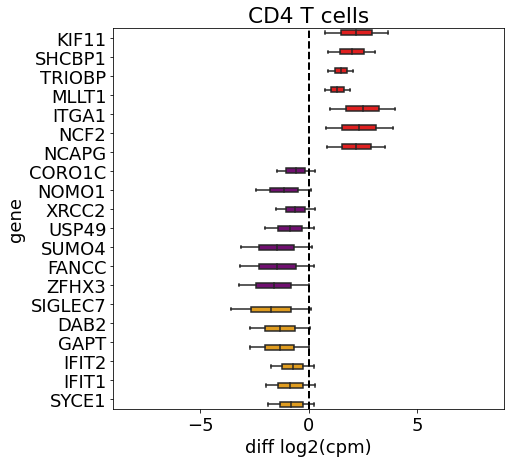

In [80]:
gene_list = ['KIF11', 'SHCBP1', 'TRIOBP', 'MLLT1', 'ITGA1', 'NCF2', 'NCAPG', 
            'CORO1C', 'NOMO1', 'XRCC2', 'USP49', 'SUMO4', 'FANCC', 'ZFHX3',
            'SIGLEC7', 'DAB2', 'GAPT', 'IFIT2', 'IFIT1', 'SYCE1'] 

path = '/home/yike/phd/dengue/figures/paper_figure/figure_V8/T_cells/'
rcParams['figure.figsize']=(7, 7)
rcParams['savefig.dpi']=300
pairwise_barplot_top2(df_CD4, df, gene_list, path, 'png', name = 'CD4 T cells')

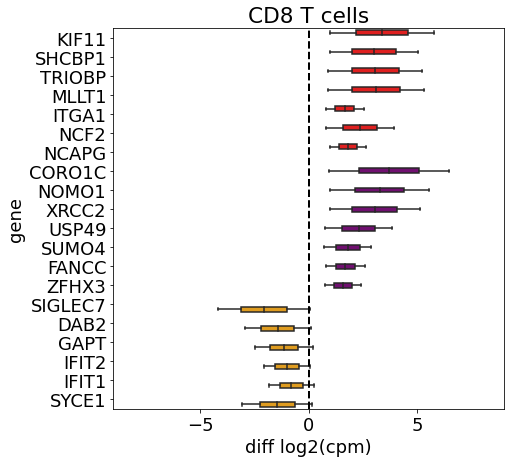

In [81]:
rcParams['figure.figsize']=(7, 7)
rcParams['savefig.dpi']=300
pairwise_barplot_top2(df_CD8, df, gene_list, path, 'png', name = 'CD8 T cells')

In [245]:
def frac_exp(adata, gene, ct, cat='fra'):  
    adata_g = adata[:, gene]

    IDs = list(adata.obs['ID'].astype('category').cat.categories)

    df_fra = pd.DataFrame(IDs, columns=['ID'])
    fra, cd = [], []
    SD_IDs = list(adata[adata.obs['Condition'] == 'S_dengue'].obs['ID'].astype('category').cat.categories)
    for ID in IDs:
        if cat == 'fra':
            fra.append((adata_g[adata_g.obs['ID'] == ID].X > 0).mean())
        elif cat == 'avg':
            fra.append((adata_g[adata_g.obs['ID'] == ID].X).mean())
        if ID in SD_IDs:
            cd.append('Severe dengue')
        else:
            cd.append('Dengue')
    df_fra['fra'] = fra
    df_fra['condition'] = cd
    
    fig, ax = plt.subplots(dpi=300)
    ax = sns.boxplot(data = df_fra, x = 'condition', y = 'fra', palette = ['navy', 'orange'])
    ax.set_xlabel(None)
    
    if cat == 'fra':
        ax.set_ylabel('Fraction of %s\nexpressing %s'%(ct, gene))
        #ax.set_ylim(0, 0.1)
        
    elif cat == 'avg':
        ax.set_ylabel('%s expression [cpm]'%gene)
        ax.set_yscale('log')
        #ax.set_ylim(0, 0.1)
    
    return {'figure': fig, 'ax': ax}

In [241]:
adata_CD4 = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD4_T_cells') & 
                          (adata_children.obs['Condition'].isin(['S_dengue', 'dengue']))]

adata_CD8 = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD8_T_cells') & 
                          (adata_children.obs['Condition'].isin(['S_dengue', 'dengue']))]

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='Fraction of CD4 T cells\nexpressing CTLA4'>}

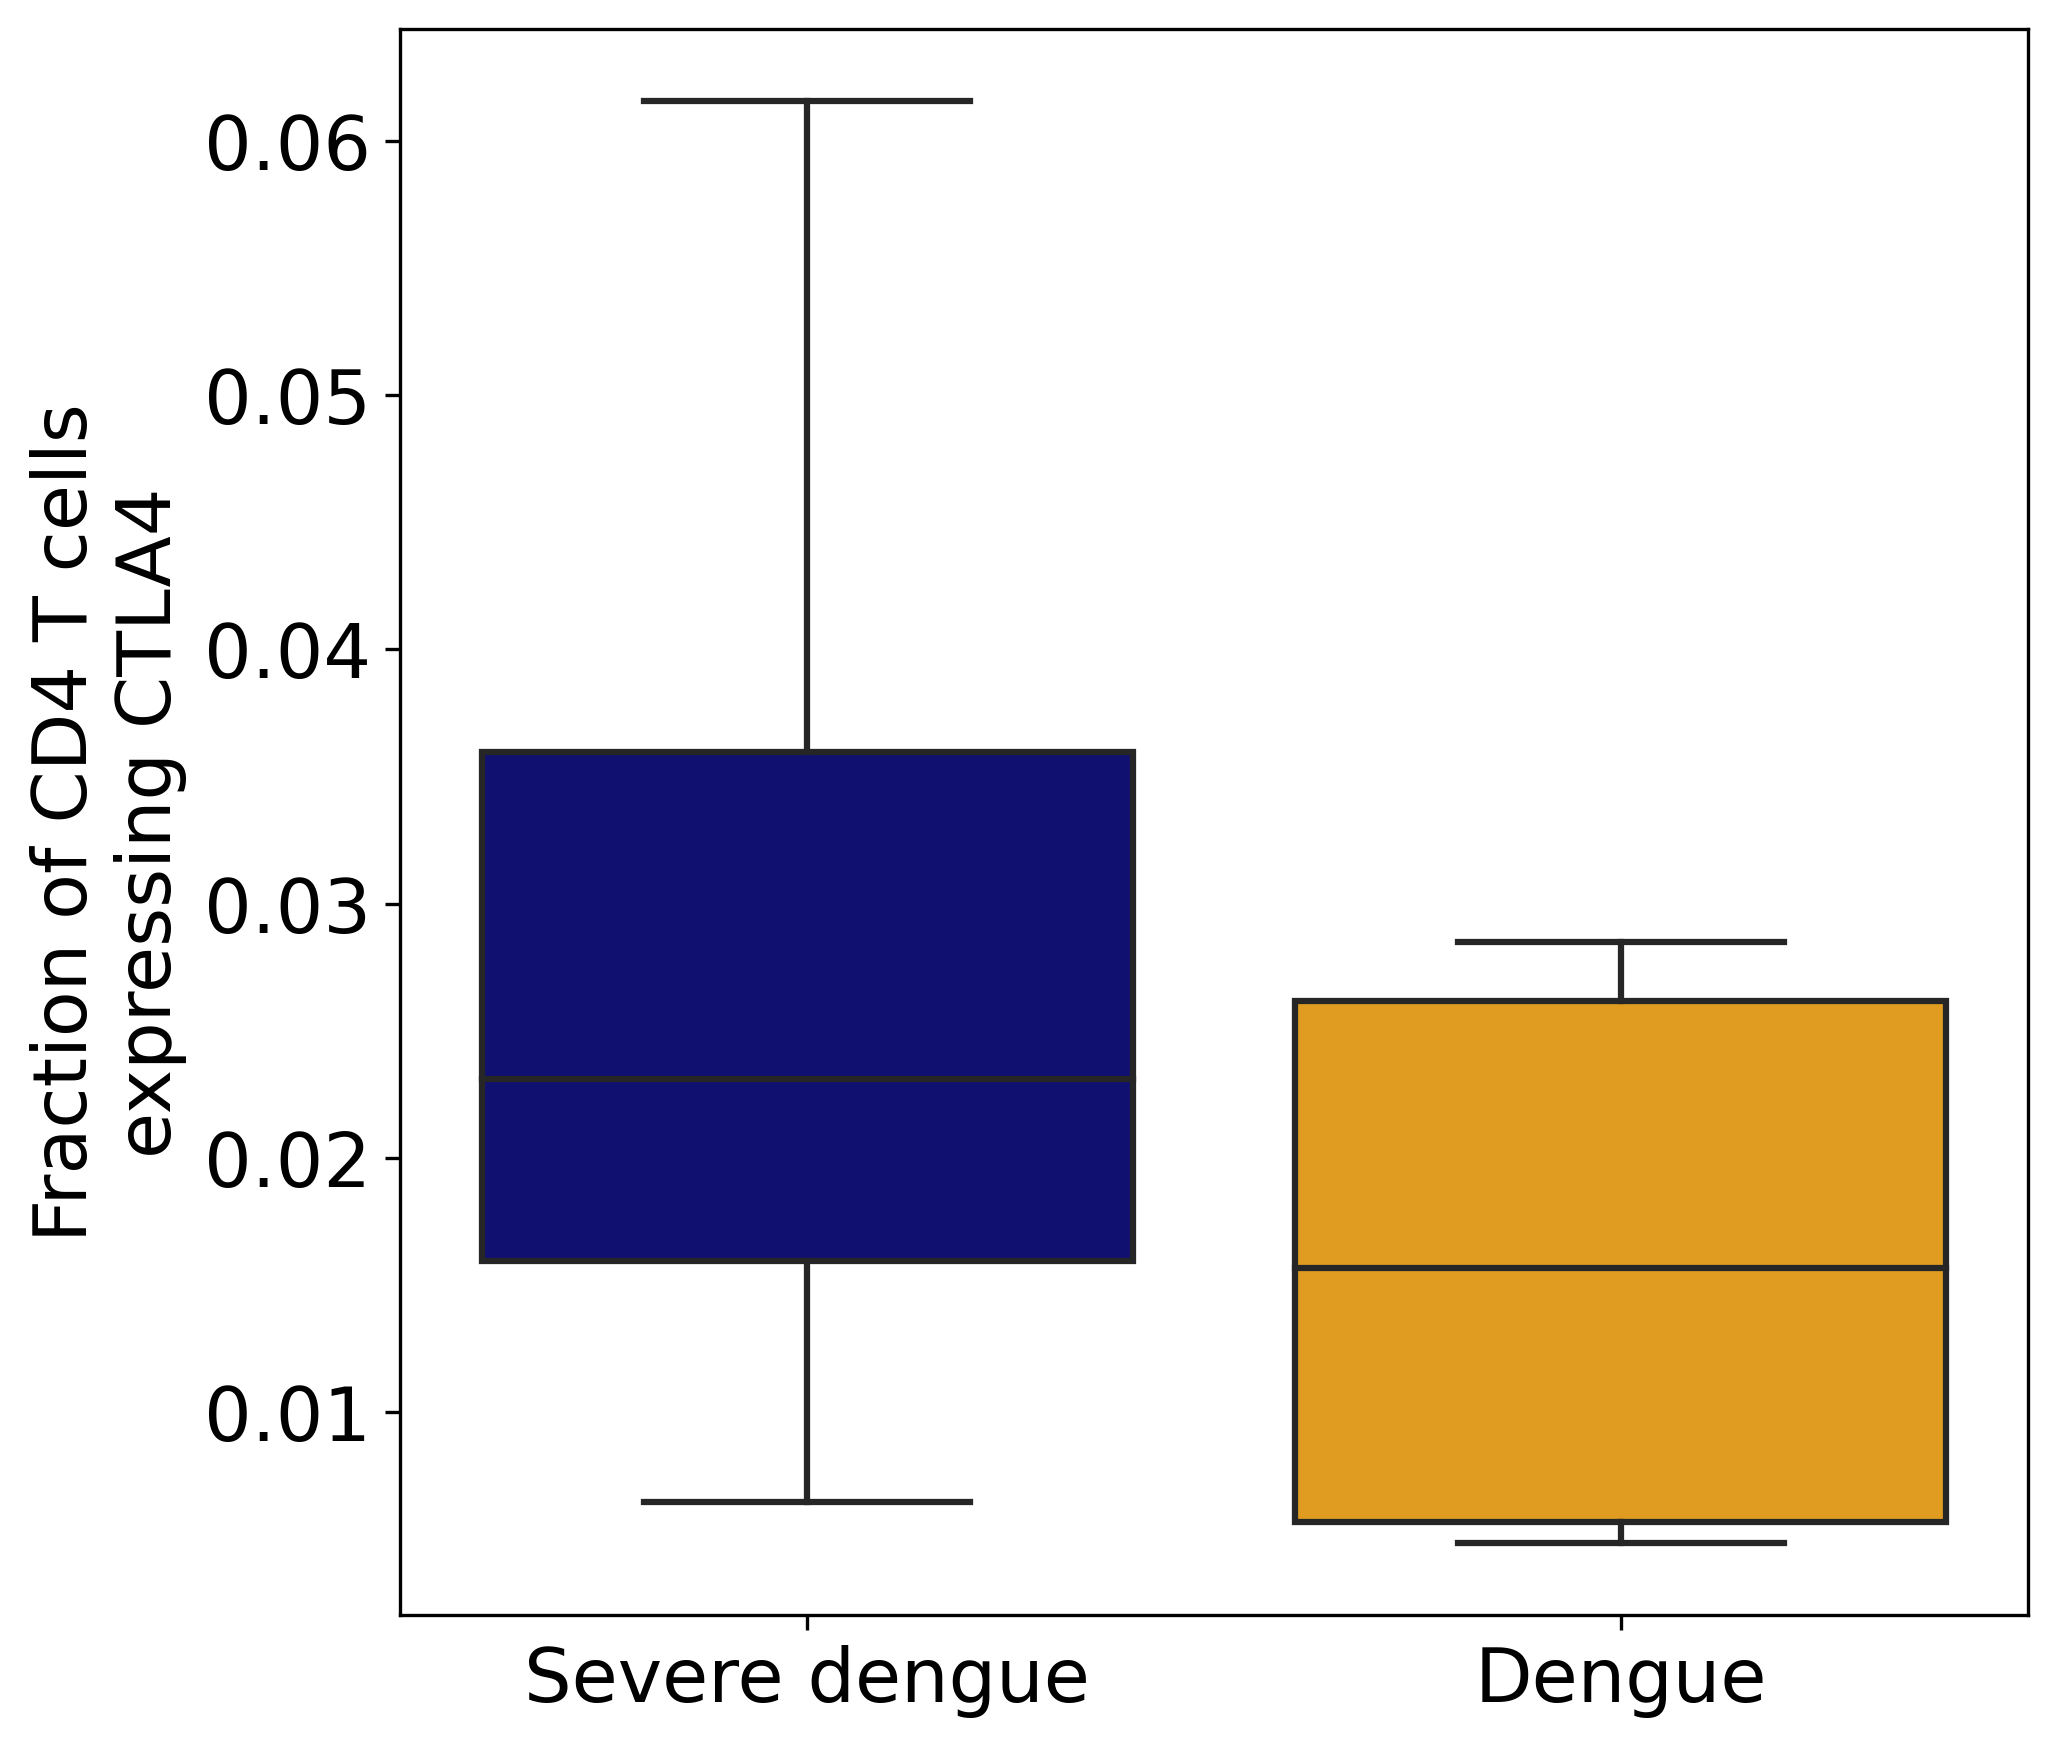

In [246]:
frac_exp(adata_CD4, 'CTLA4', 'CD4 T cells', cat='fra')

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='Fraction of CD8 T cells\nexpressing CTLA4'>}

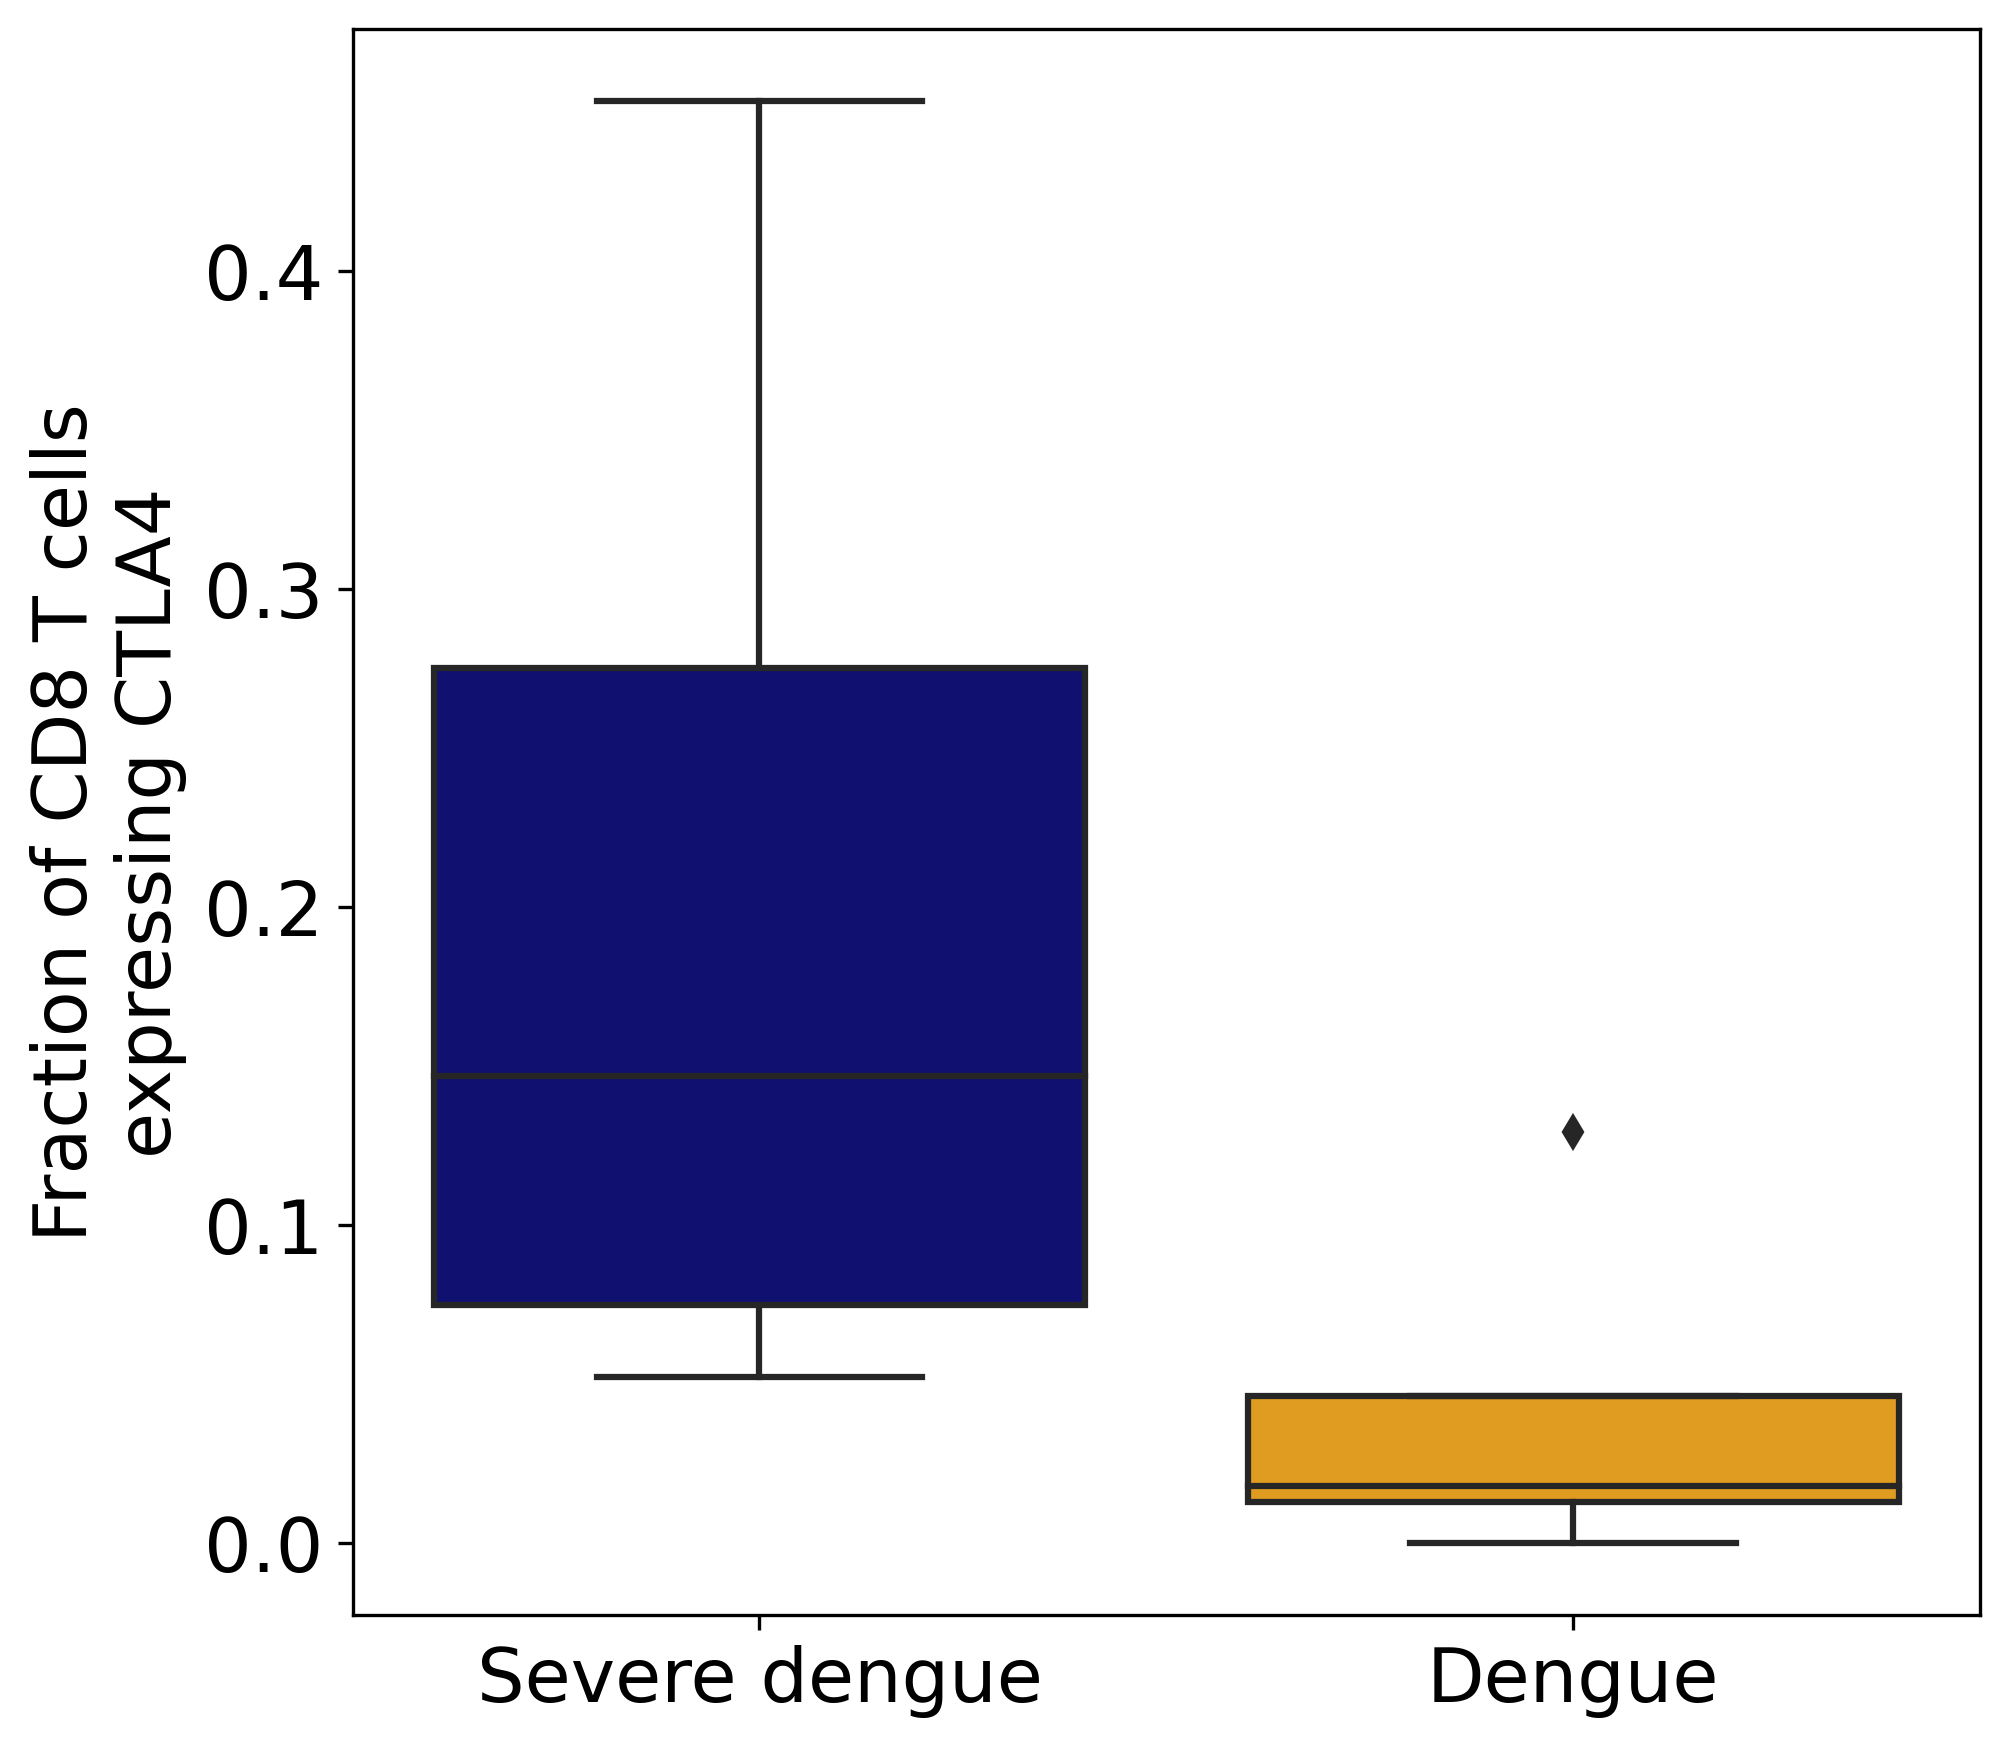

In [247]:
frac_exp(adata_CD8, 'CTLA4', 'CD8 T cells', cat='fra')

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='Fraction of CD8 T cells\nexpressing CD86'>}

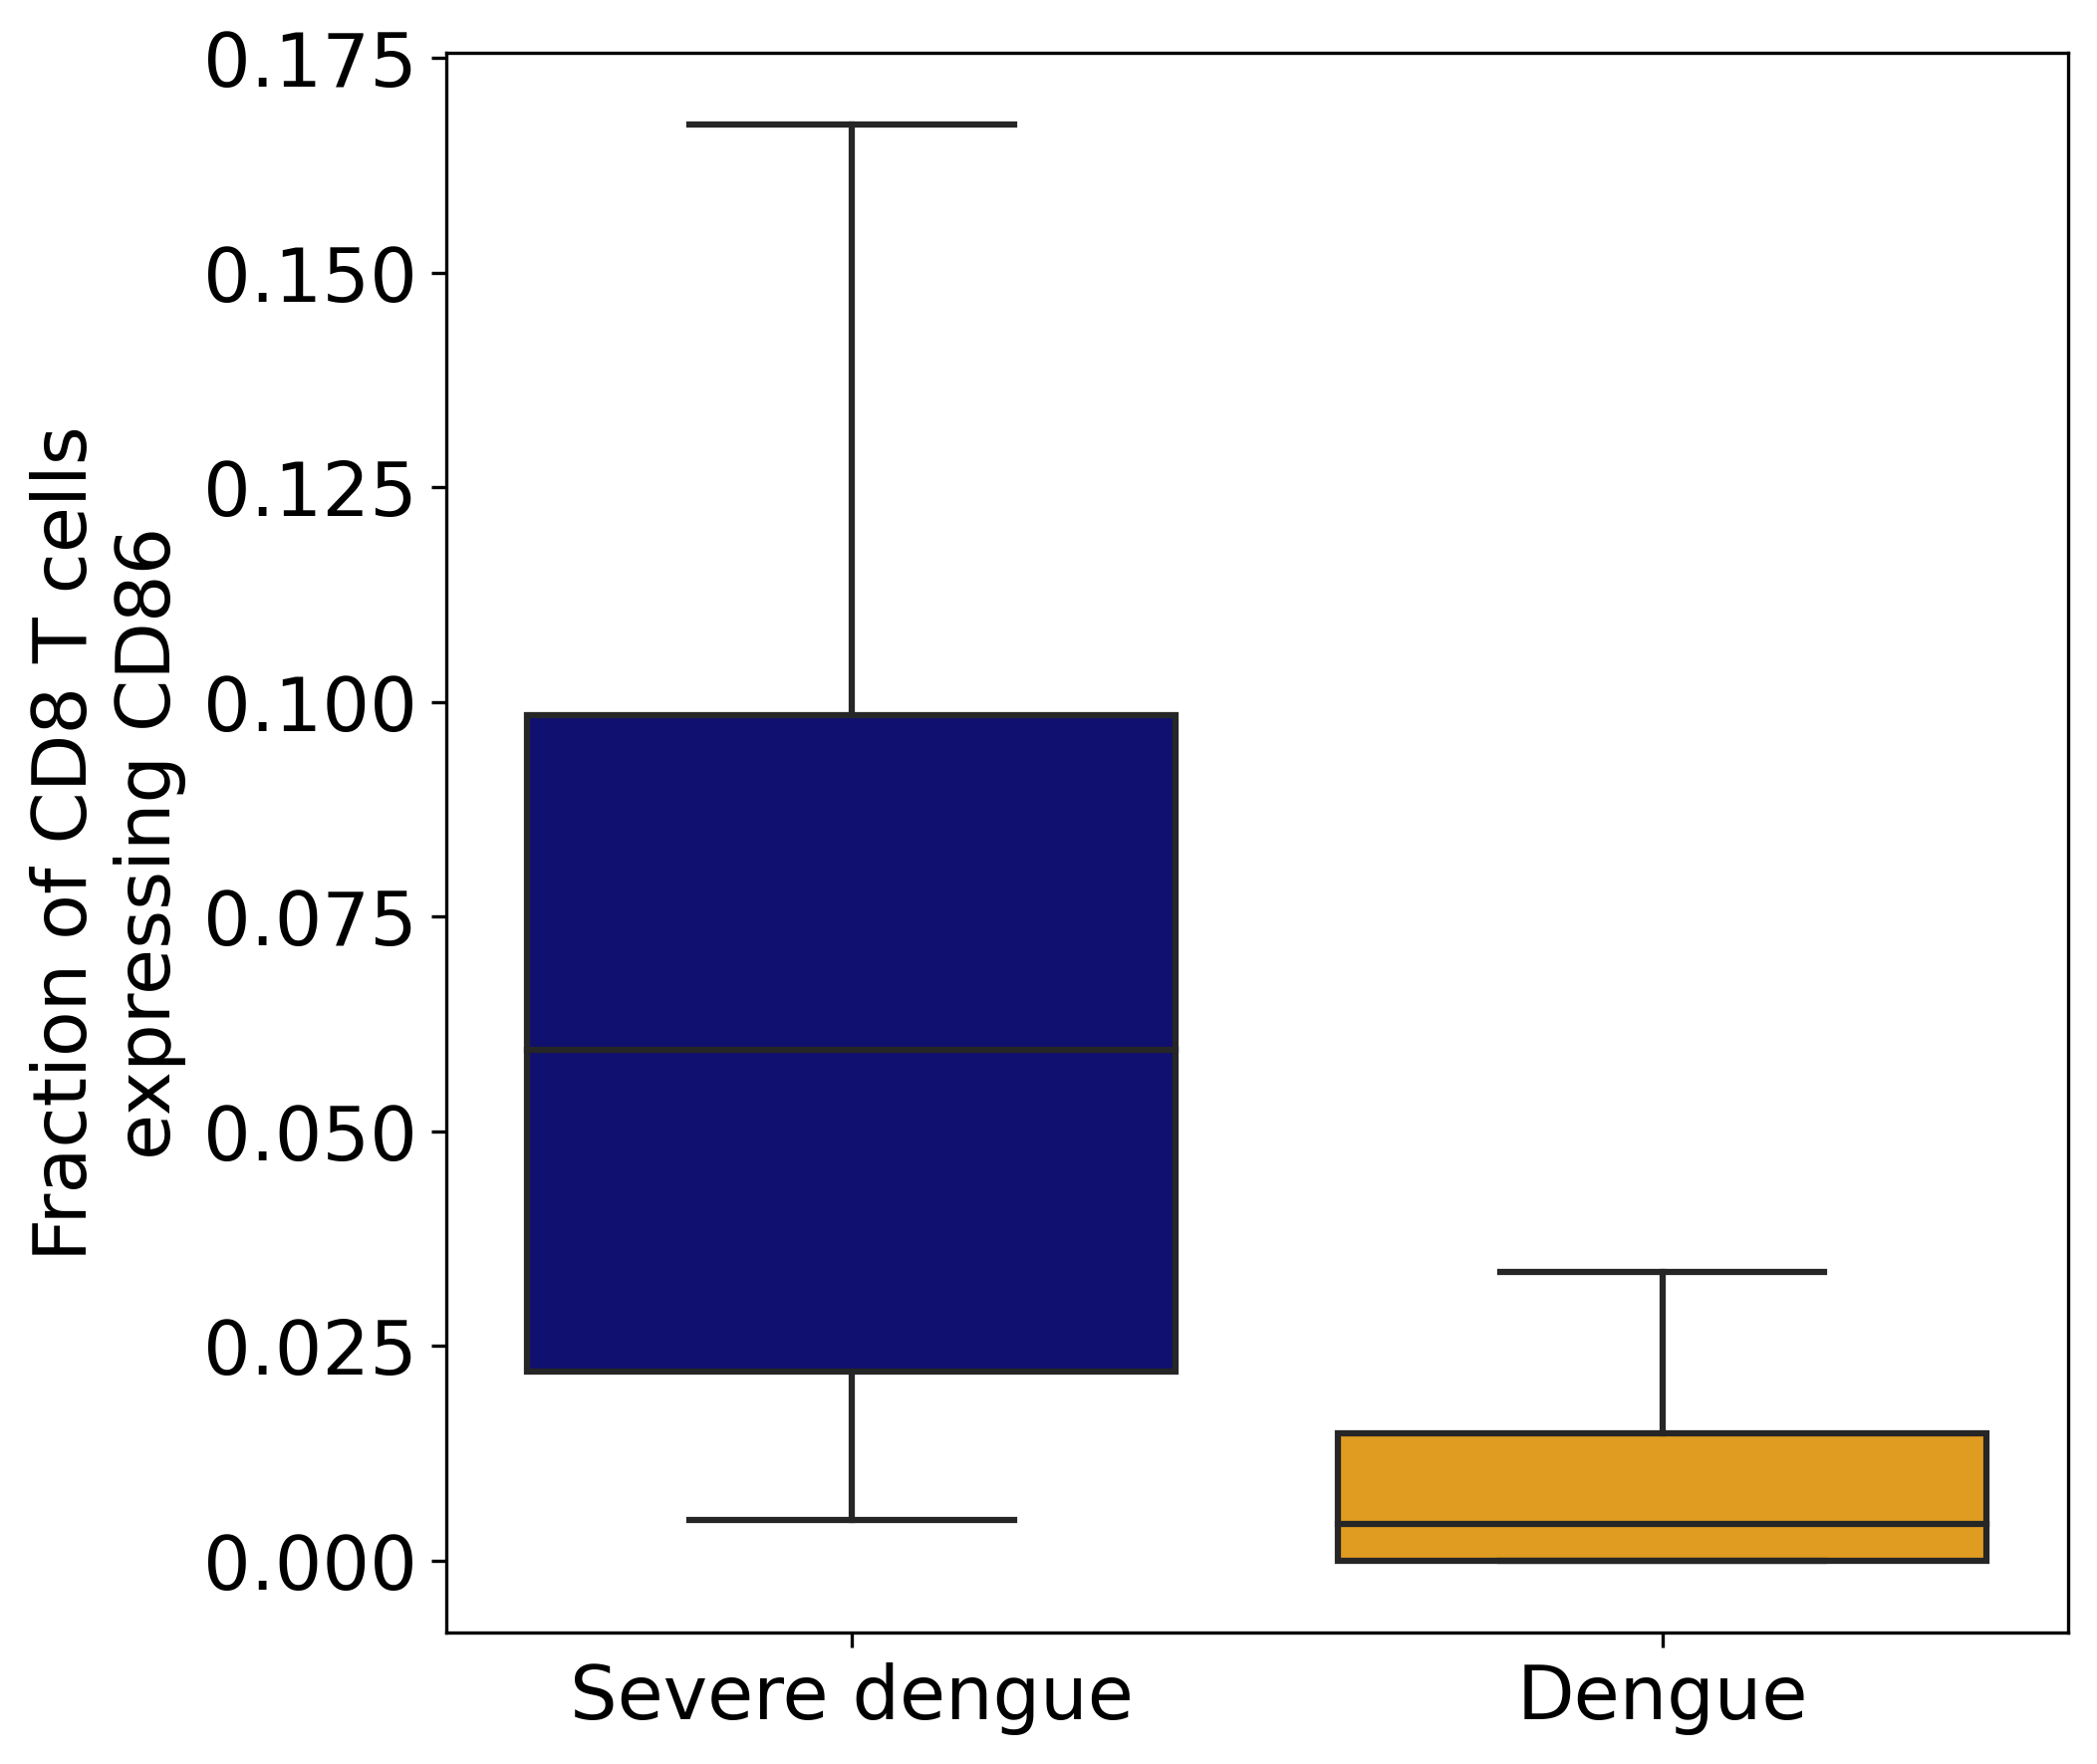

In [248]:
frac_exp(adata_CD8, 'CD86', 'CD8 T cells', cat='fra')

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='CTLA4 expression [cpm]'>}

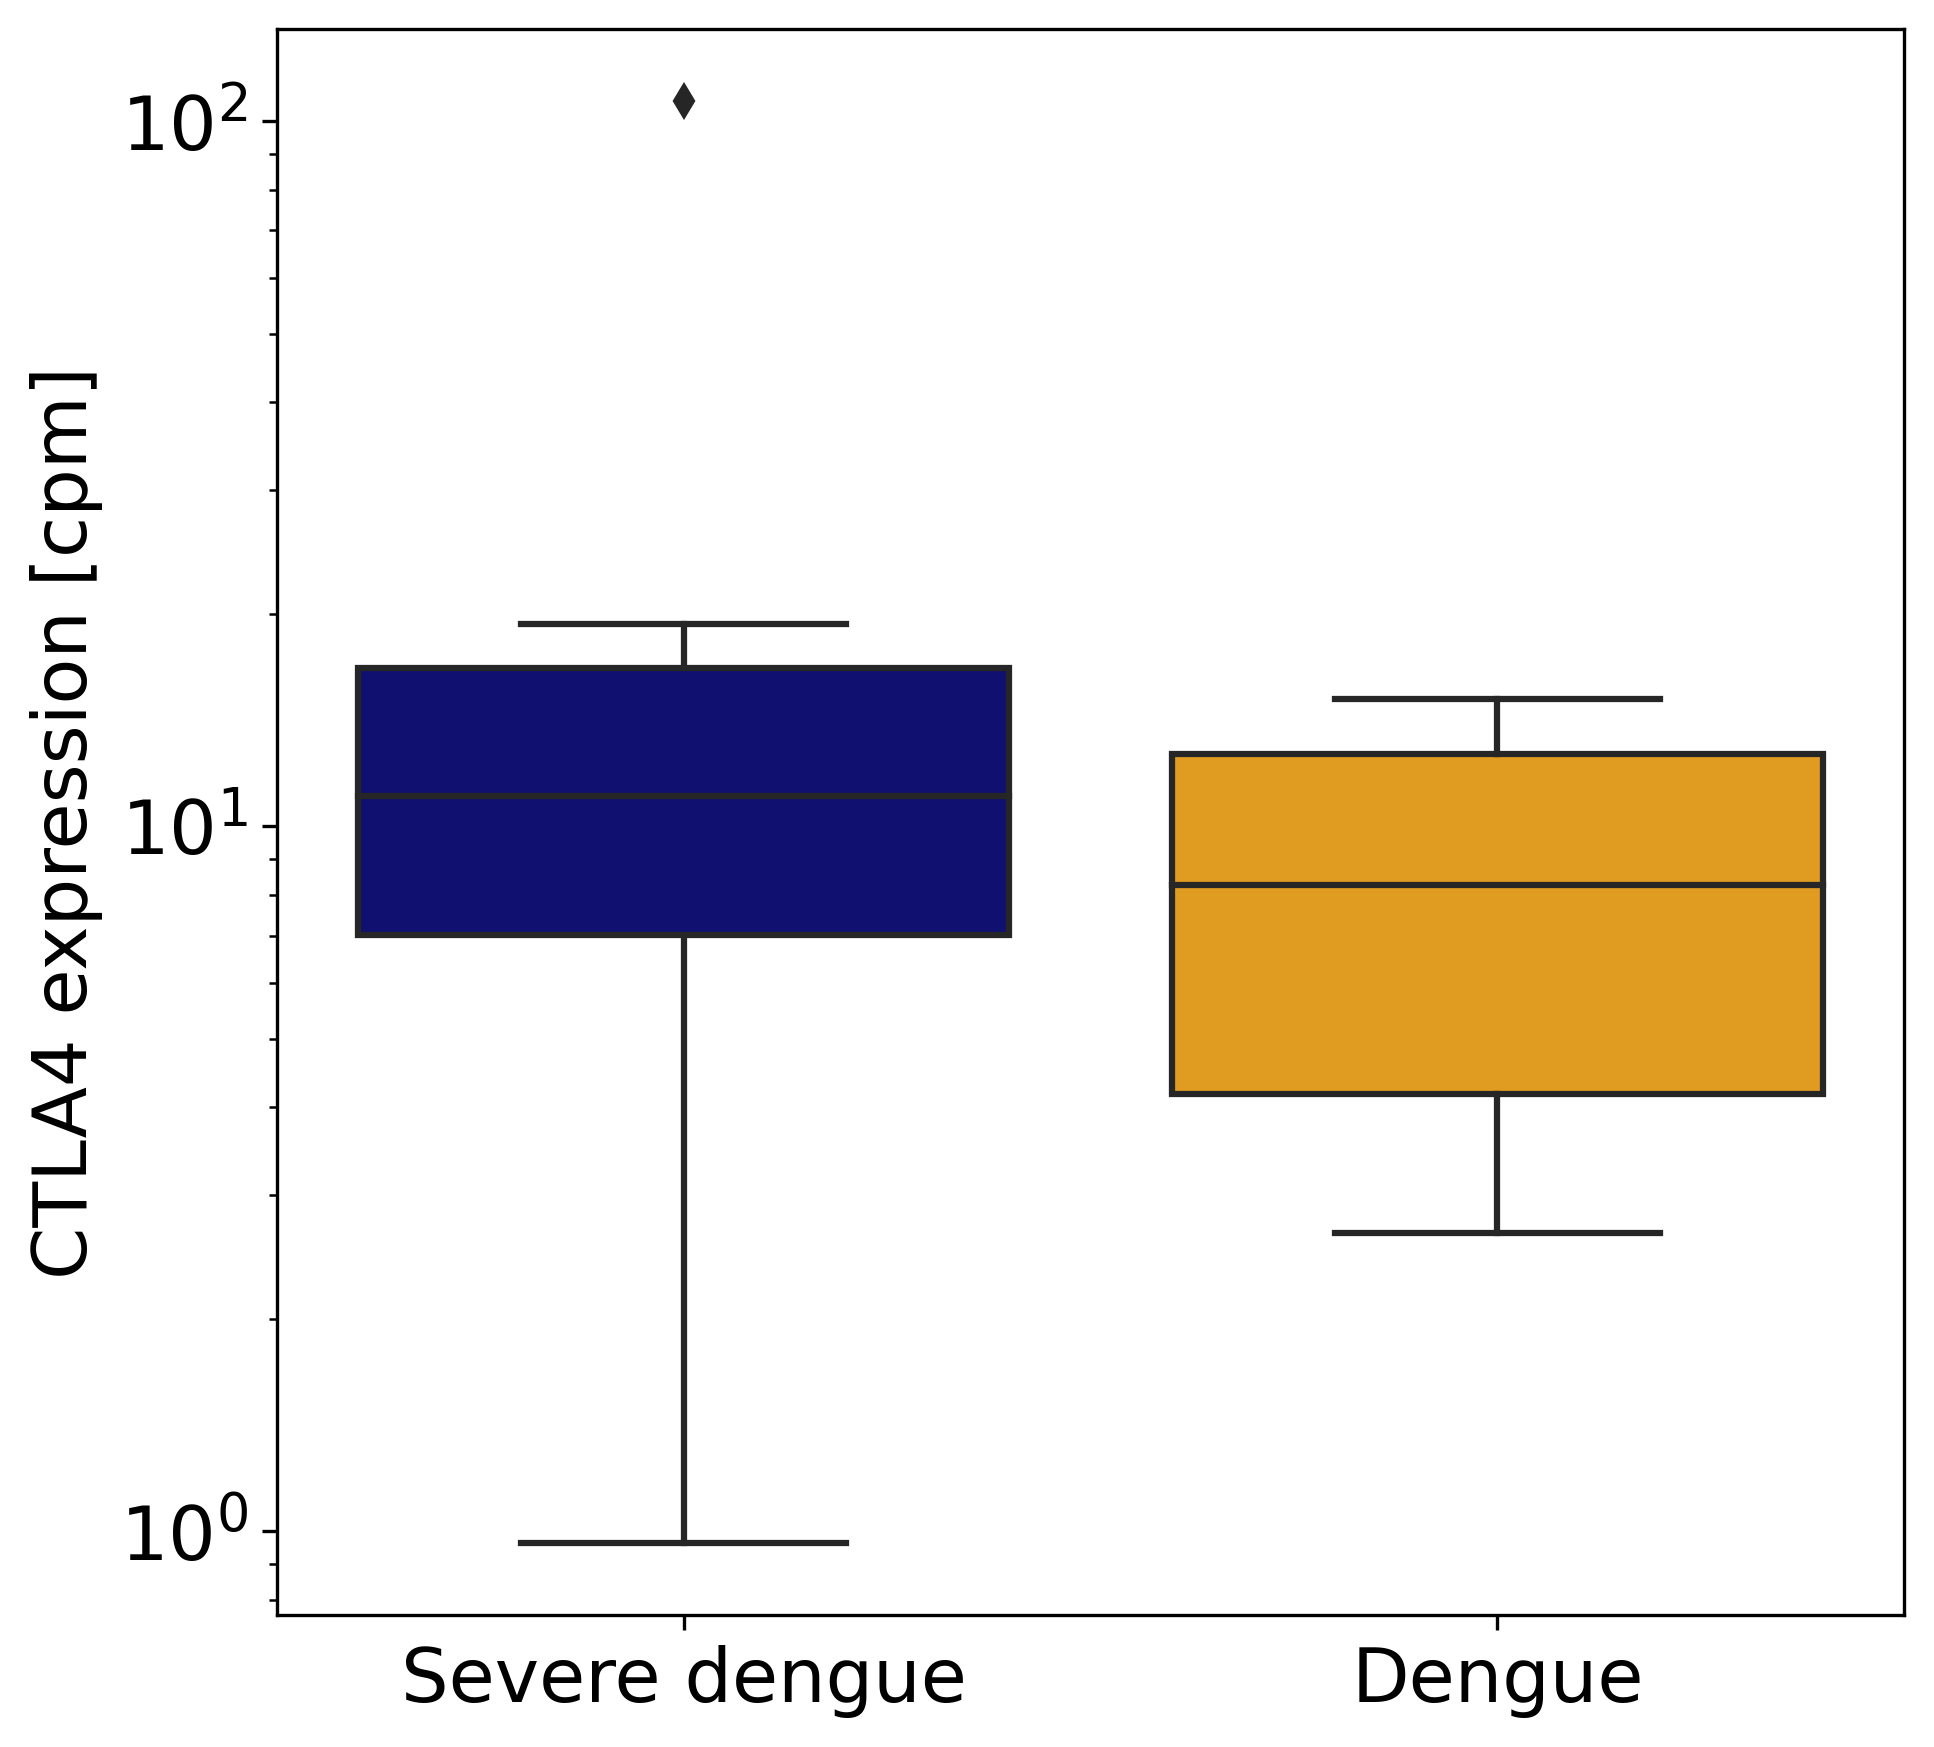

In [251]:
frac_exp(adata_CD4, 'CTLA4', 'CD4 T cells', cat='avg')

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='Fraction of CD4 T cells\nexpressing FOXP3'>}

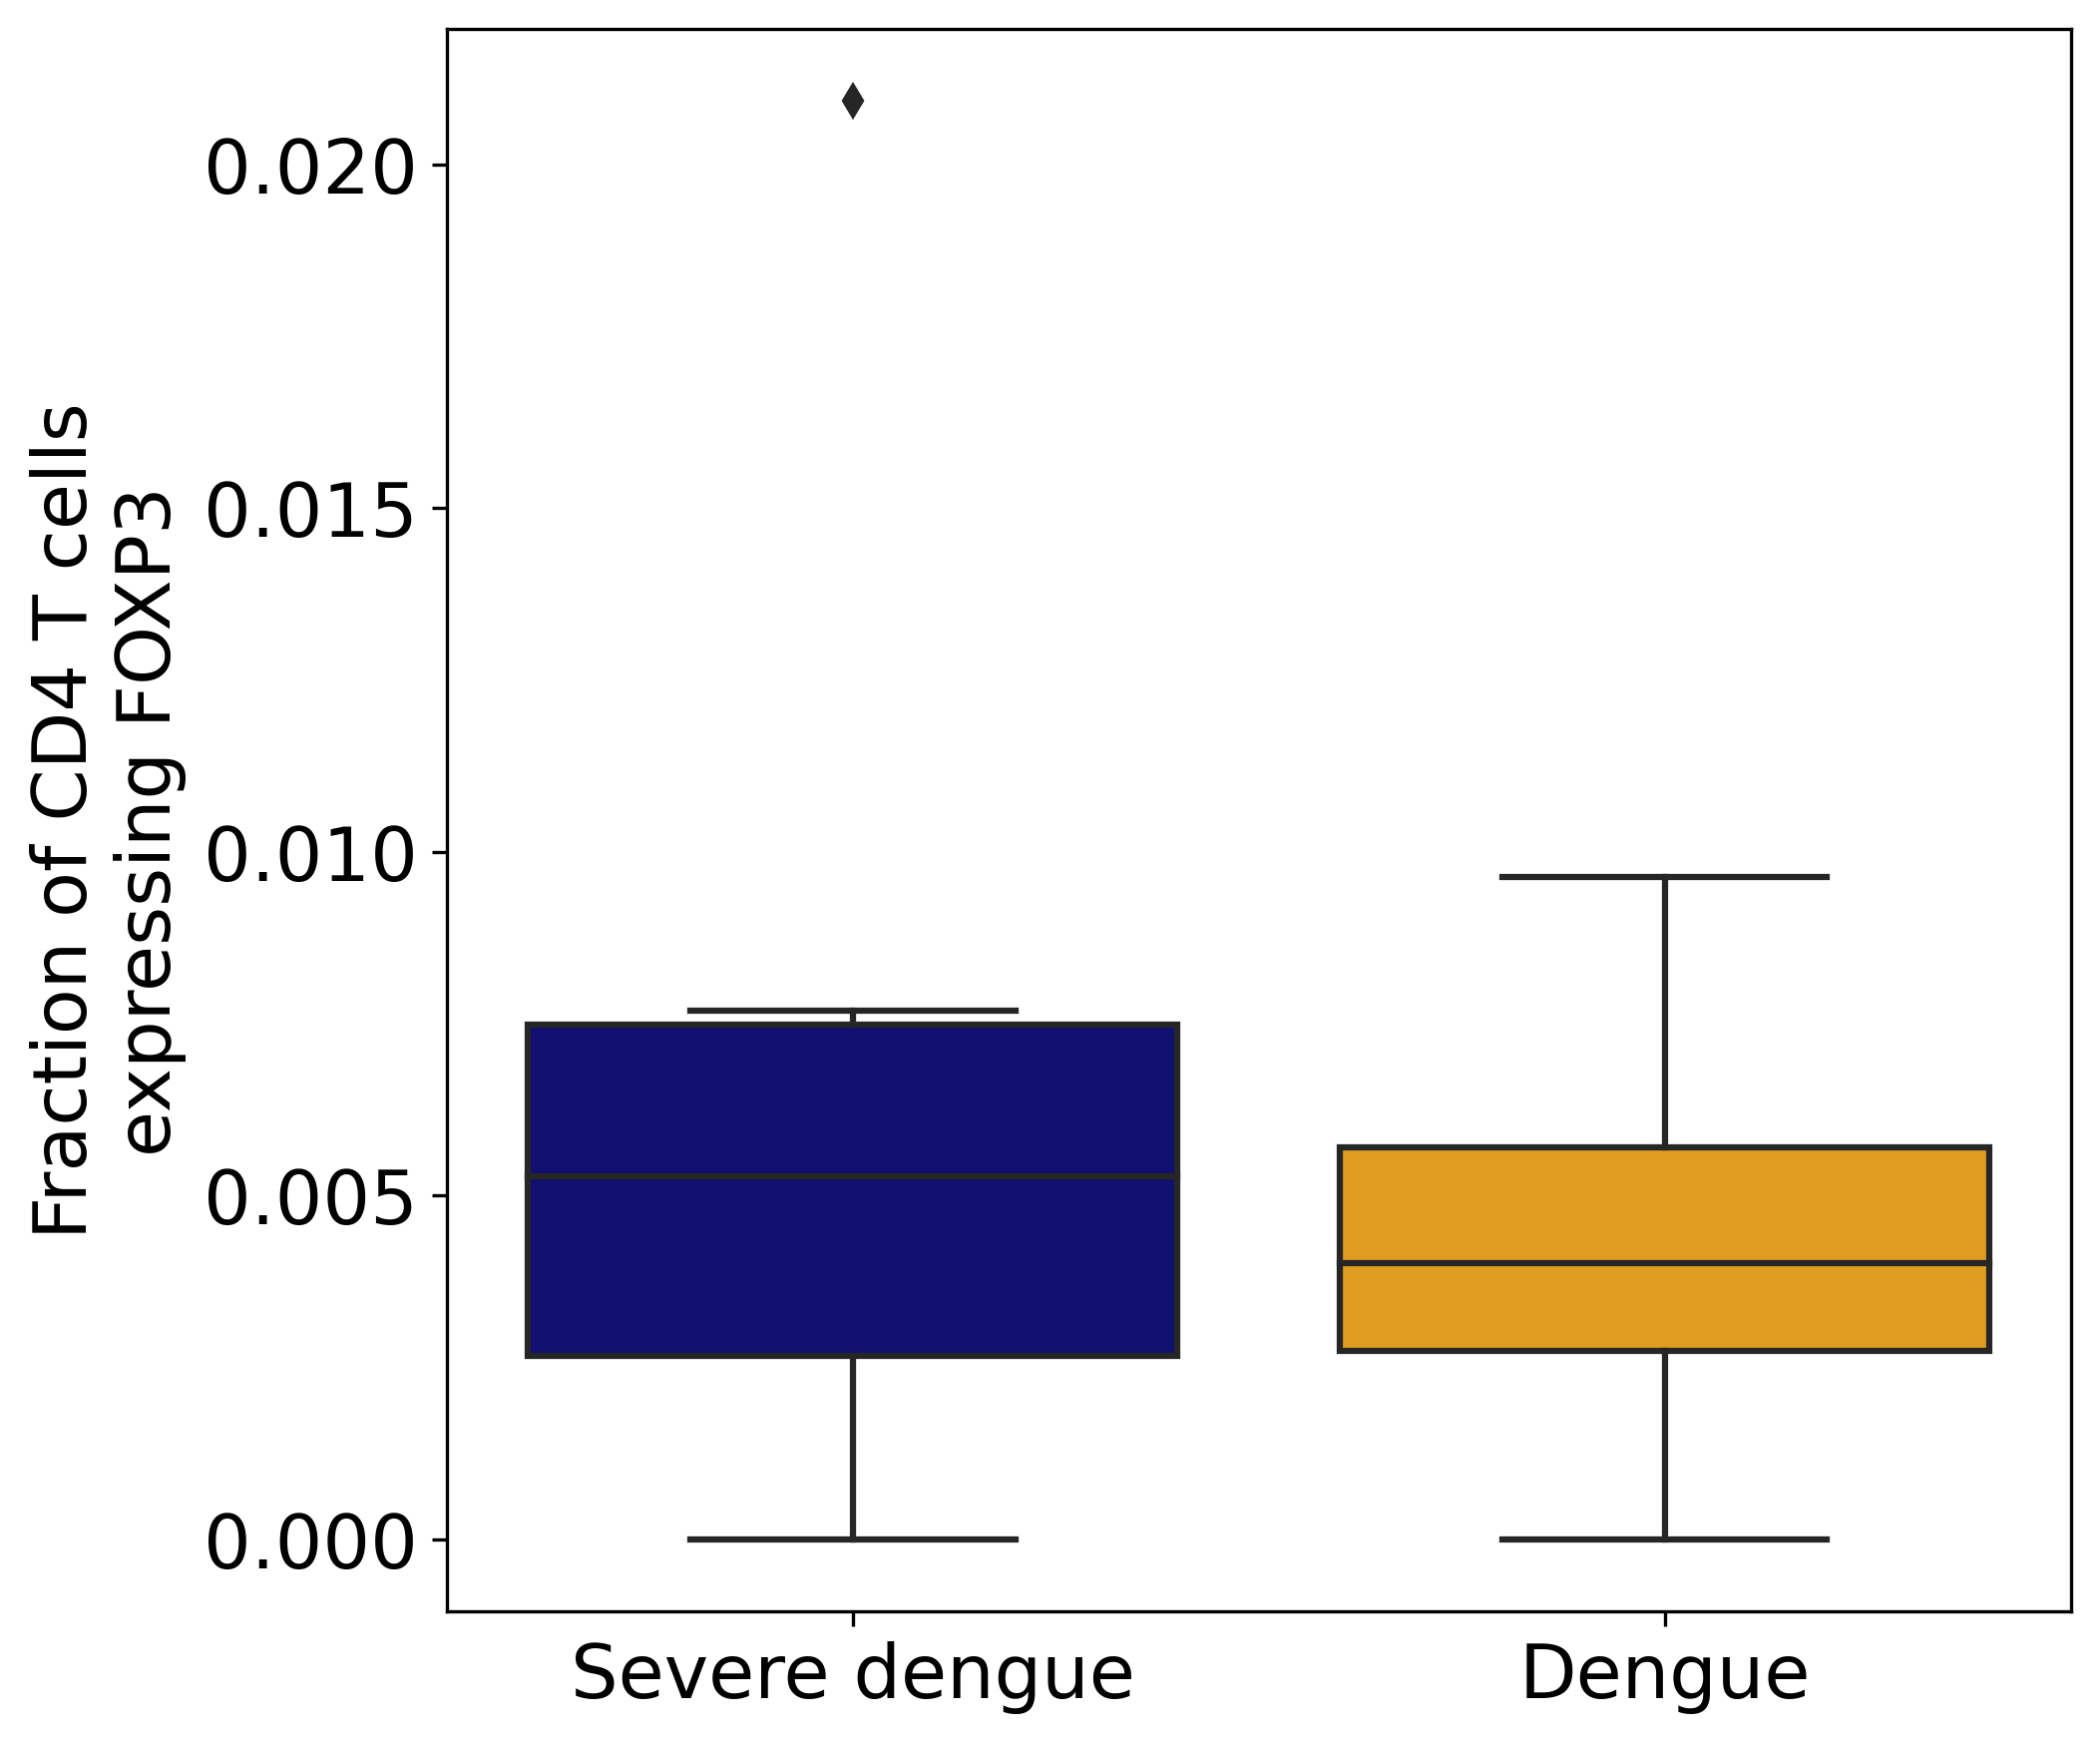

In [249]:
frac_exp(adata_CD4, 'FOXP3', 'CD4 T cells', cat='fra')

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='FOXP3 expression [cpm]'>}

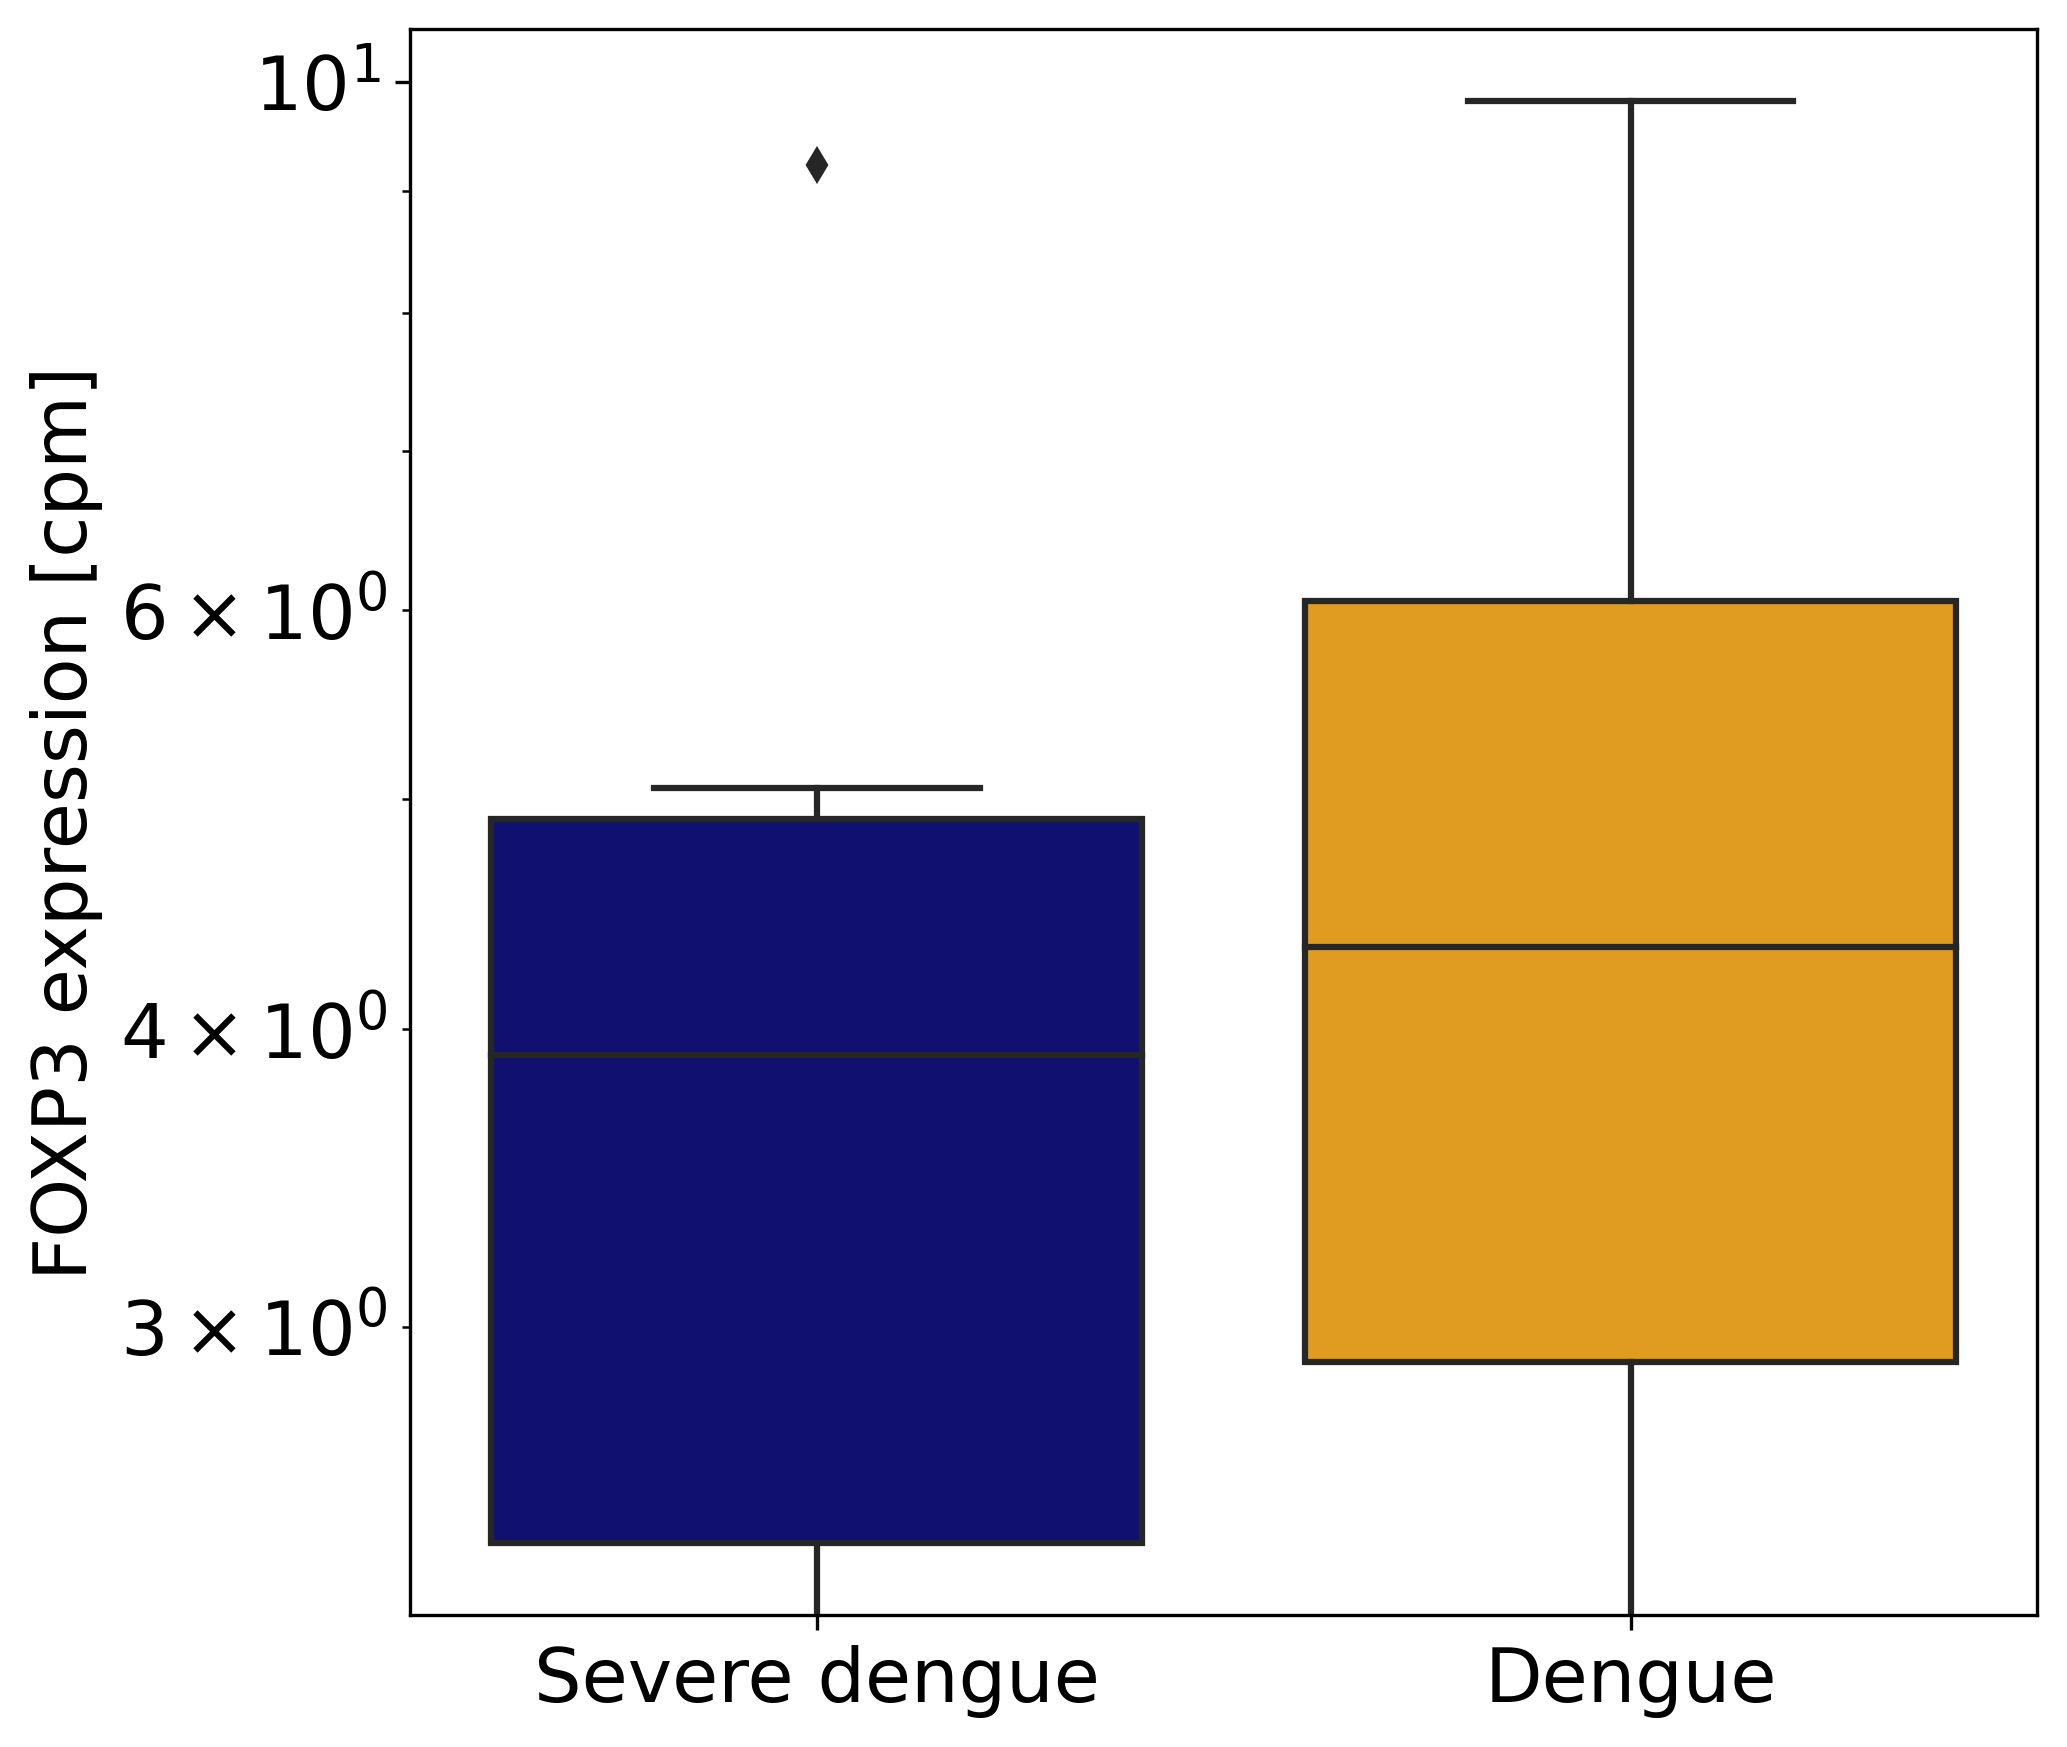

In [250]:
frac_exp(adata_CD4, 'FOXP3', 'CD4 T cells', cat='avg')